- Scipy : is a project aiming to unify and federate a set of Python libraries for scientific use. Scipy uses the arrays and matrices of the NumPy module.

- librosa : It is a Python module to analyze audio signals in general but geared more towards music. It includes the nuts and bolts to build a MIR(Music information retrieval) system.

- IPython.display : lets you play audio directly in your notebook.

- Librosa : is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio

In [ ]:
import kagglehub

dataset_path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
genres = ['blues', 'classical', 'country', 'rock', 'disco', 'reggae', 'hiphop', 'jazz', 'metal', 'pop']
gtzan_dir = os.path.join(dataset_path, "Data/genres_original")

num_genres = len(genres)

100%|██████████| 1.21G/1.21G [00:14<00:00, 88.8MB/s]

Extracting files...


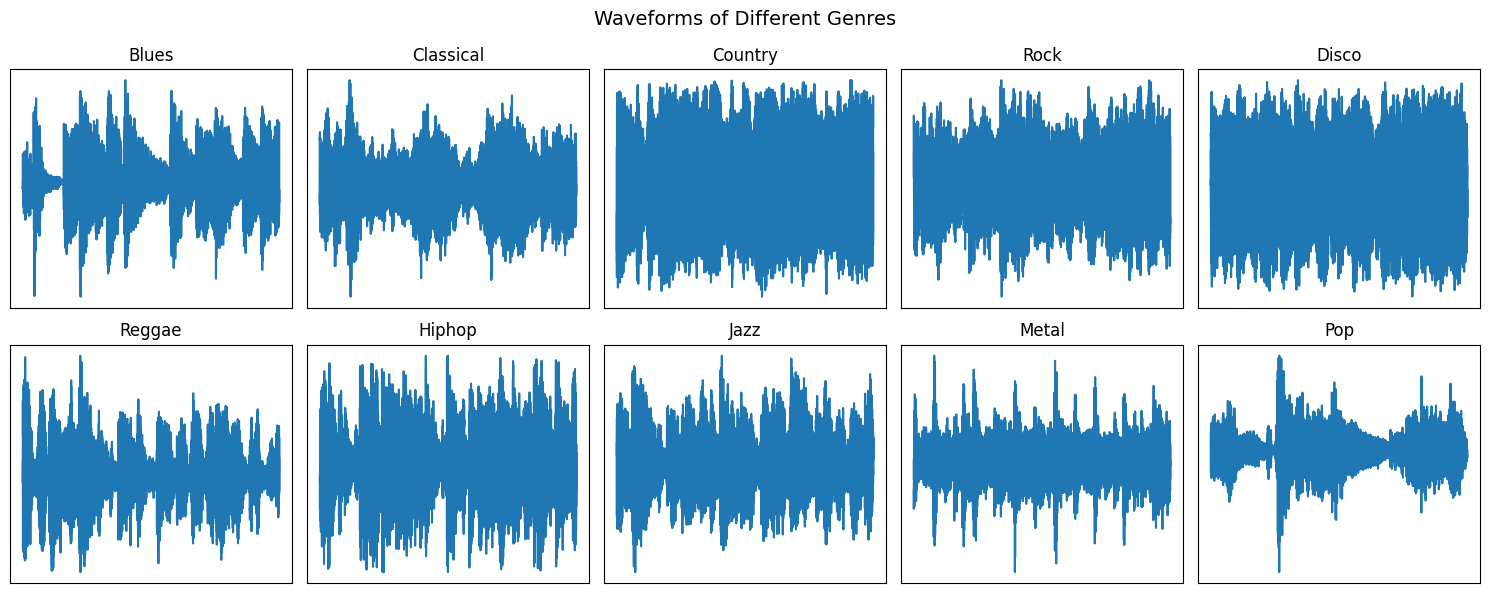

In [ ]:
# Create subplots for waveforms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("Waveforms of Different Genres", fontsize=14)

for i, genre in enumerate(genres):
    file_path = os.path.join(gtzan_dir, genre, f"{genre}.00005.wav")
    y, sr = librosa.load(file_path, duration=5.0, sr=None)
    time = np.linspace(0, len(y) / sr, num=len(y))

    ax = axes[i // 5, i % 5]
    ax.plot(time, y)
    ax.set_title(genre.capitalize())
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("genres_waveforms.png", dpi=200)
plt.show()

In [ ]:
sample_path = os.path.join(gtzan_dir, "rock", "rock.00000.wav")

y ,sr = librosa.load(sample_path, duration=30.0, sr=None)

print("Audio Data Shape: ", y.shape)
print("Sampling Rate: ", sr)

Audio Data Shape:  (661500,)
Sampling Rate:  22050


In [ ]:
print(y) # Return a 1D array

[-0.03344727 -0.05490112 -0.05435181 ... -0.1289978  -0.14007568
 -0.08935547]


Audio is represented as a 1D-Array

## Playing Audio

In [ ]:
for genre in genres:
    sample_path = os.path.join(gtzan_dir, genre, f"{genre}.00000.wav")

    try:
        y, sr = librosa.load(sample_path, duration=30.0, sr=None)
        print(f"Playing {genre} sample:")
        display(Audio(y, rate=sr))
    except Exception as e:
        print(f"Error loading {genre} sample: {e}")

##Visualizing Audio

#### Plot Raw Wave File

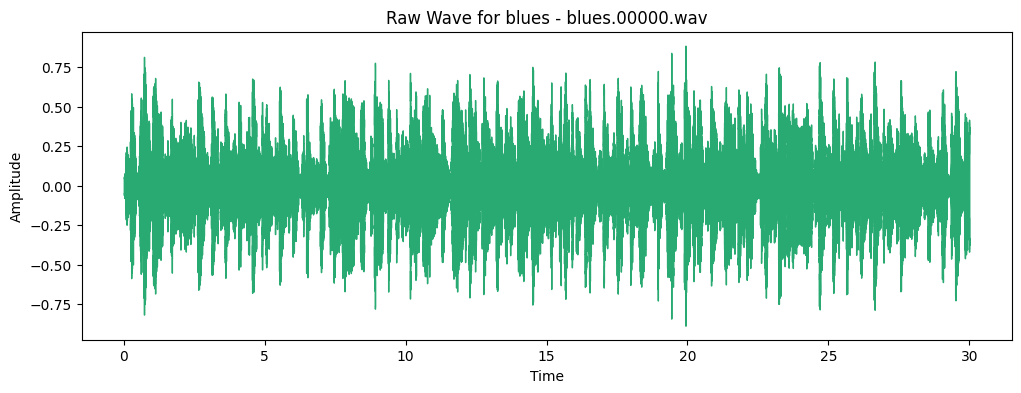

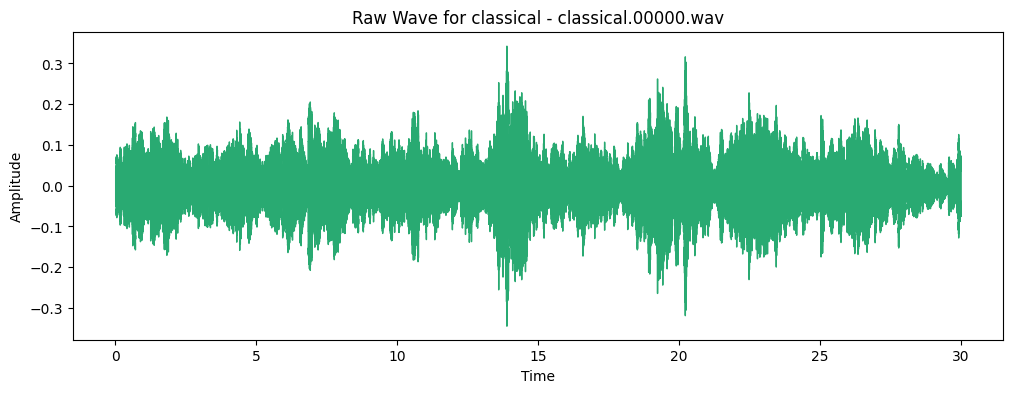

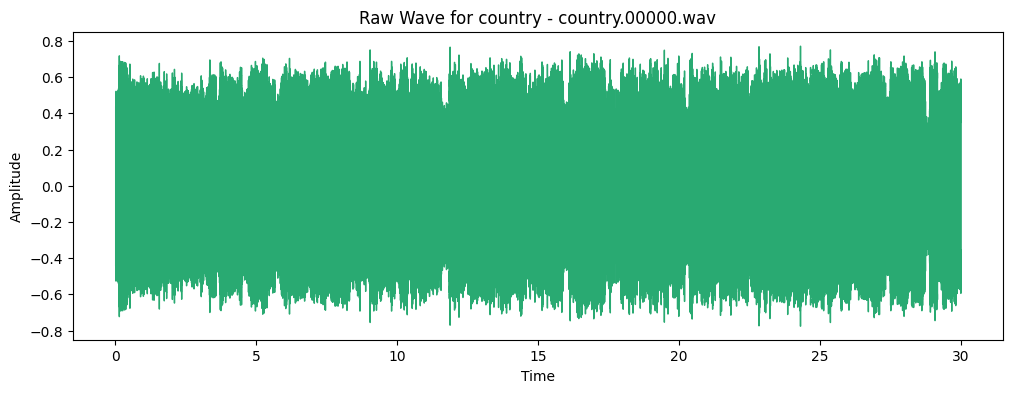

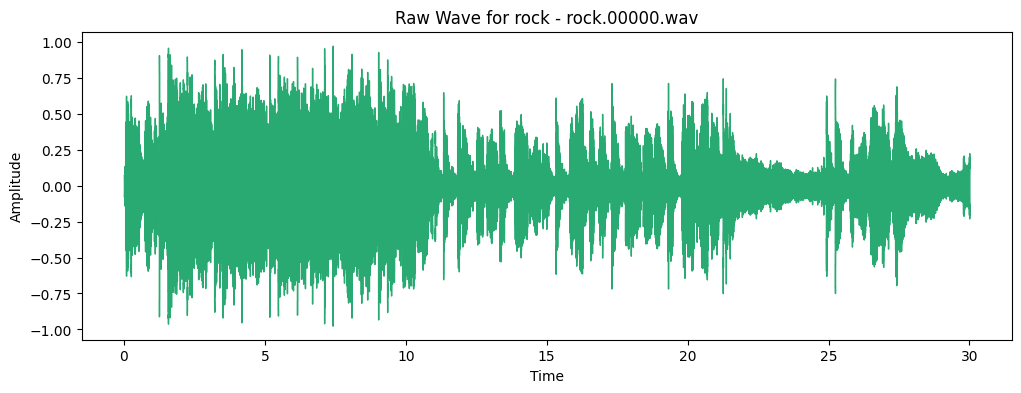

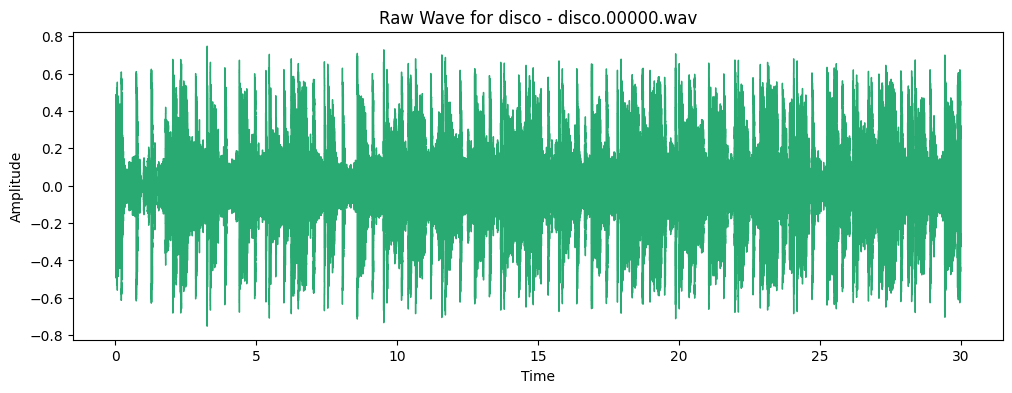

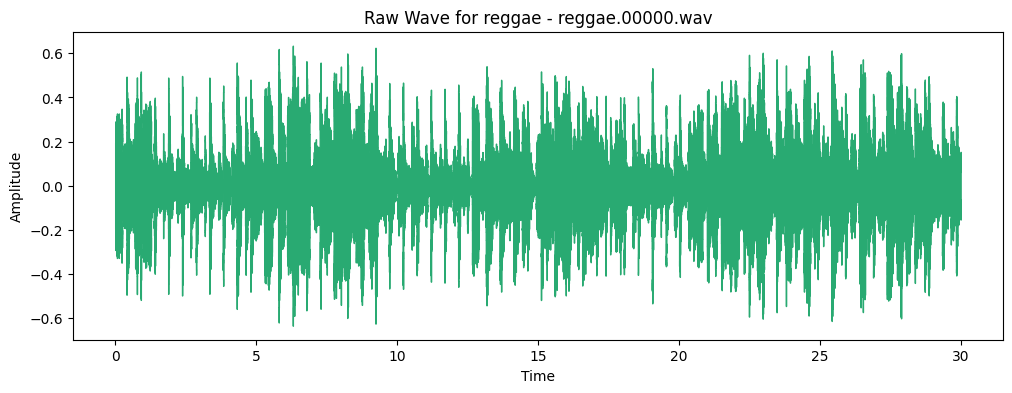

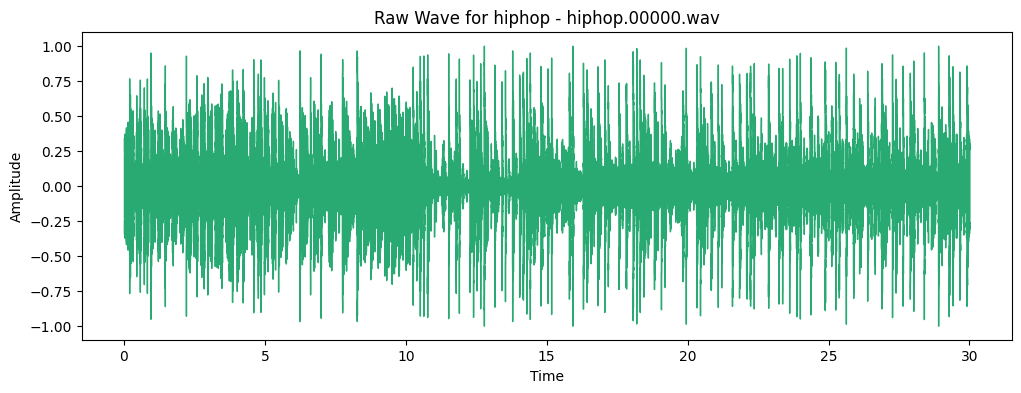

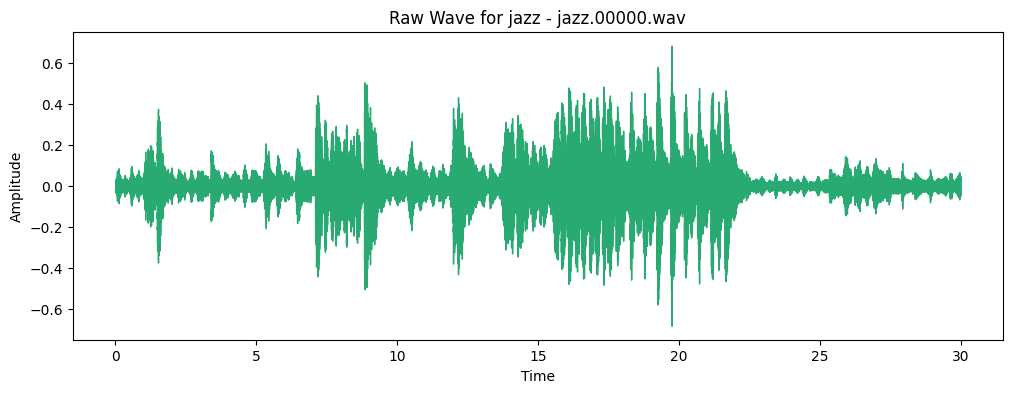

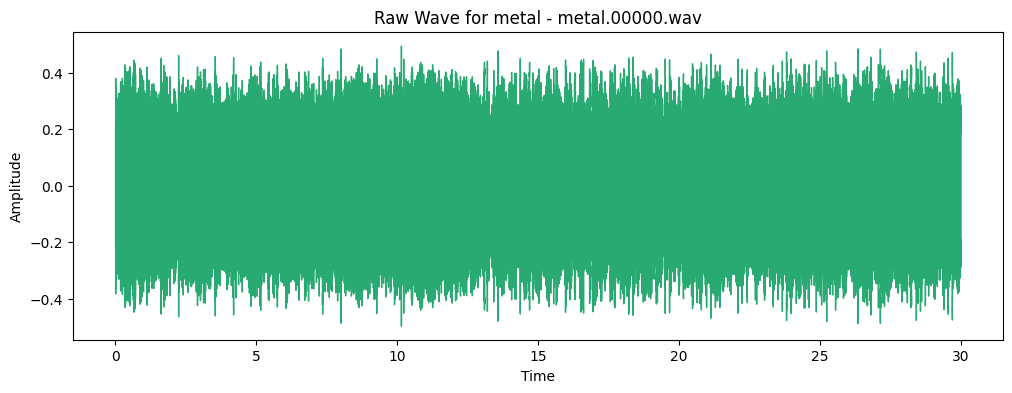

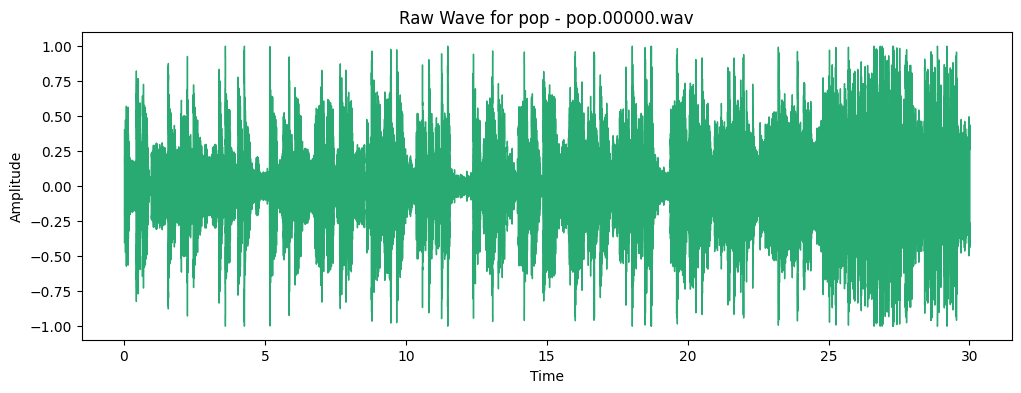

In [ ]:
for genre in genres:
    data_path = os.path.join(gtzan_dir, genre, f"{genre}.00000.wav")
    data, sr = librosa.load(data_path, duration=30.0, sr=None)

    plt.figure(figsize=(12, 4))
    plt.title(f"Raw Wave for {genre} - {genre}.00000.wav")
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    librosa.display.waveshow(data, color="#29AA72")
    plt.show()

#### Plot Spectrogram

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, but one can also see how energy levels vary over time.

In [ ]:
for genre in genres:
    data_path = os.path.join(gtzan_dir, genre, f"{genre}.00000.wav")
    data, sr = librosa.load(data_path, duration=30.0, sr=None)

    X = librosa.stft(data)
    X_db = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 4))
    plt.title(f"Spectrogram for {genre} - {genre}.00000.wav")
    librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

#### Spectral Rolloff

Spectral rolloff is a feature used in audio signal processing to describe the frequency below which a specified percentage of the total spectral energy is contained. It's often used in tasks like music genre classification, speech recognition, and audio analysis.

Definition

- The spectral rolloff frequency is the point below which a given percentage (roll_percent) of the total spectral energy lies.
- By default, roll_percent = 0.85, meaning it captures 85% of the energy.

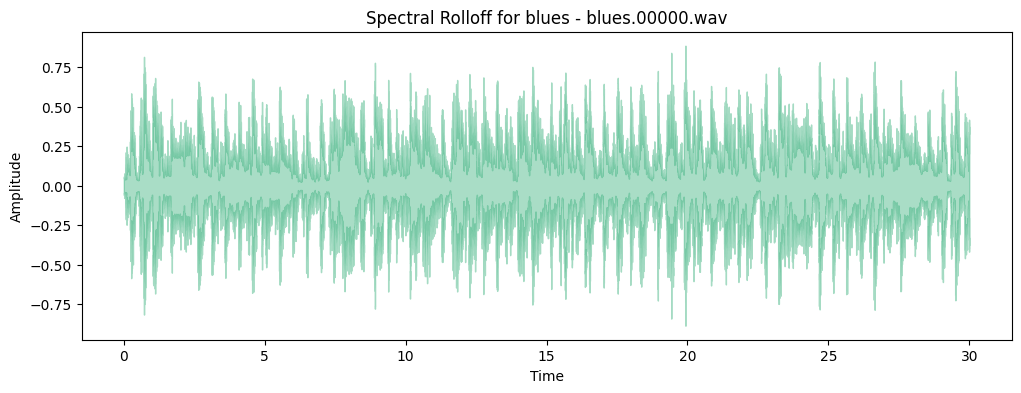

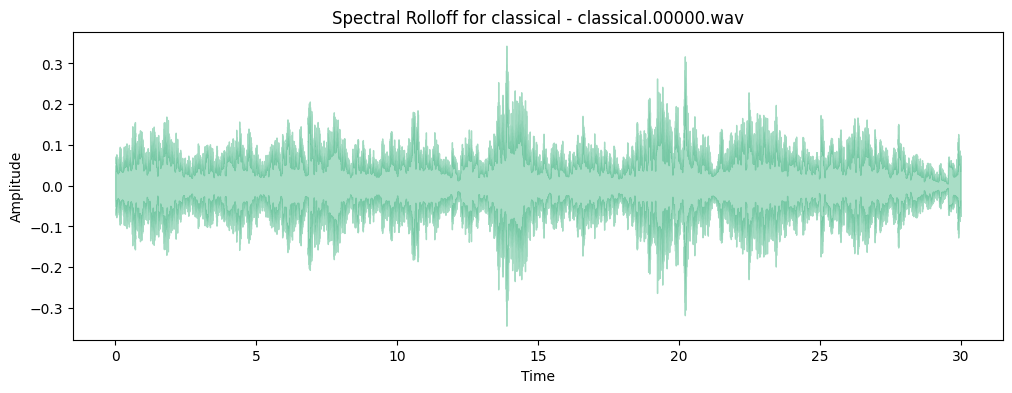

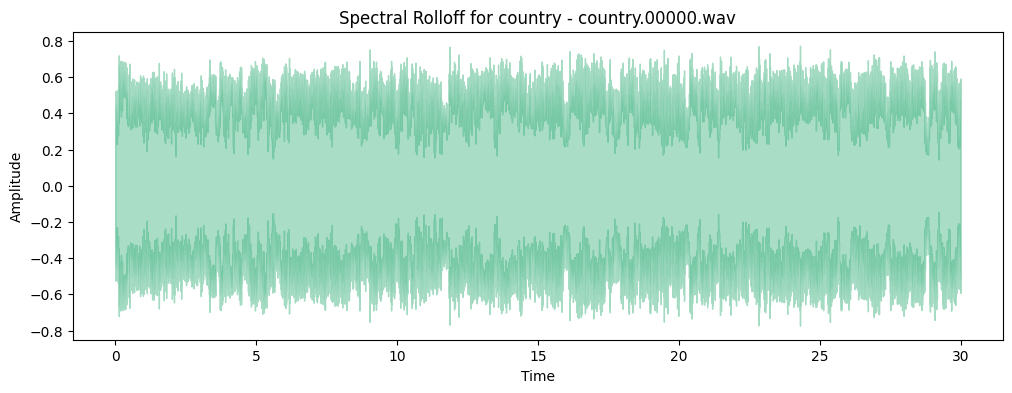

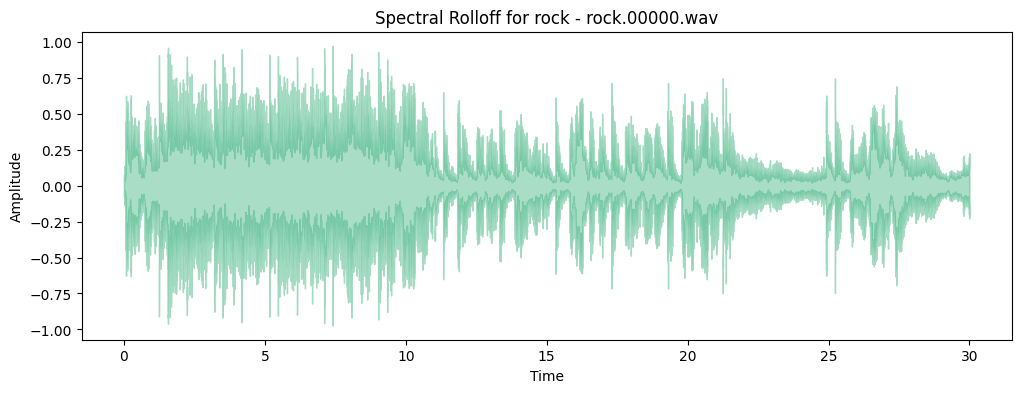

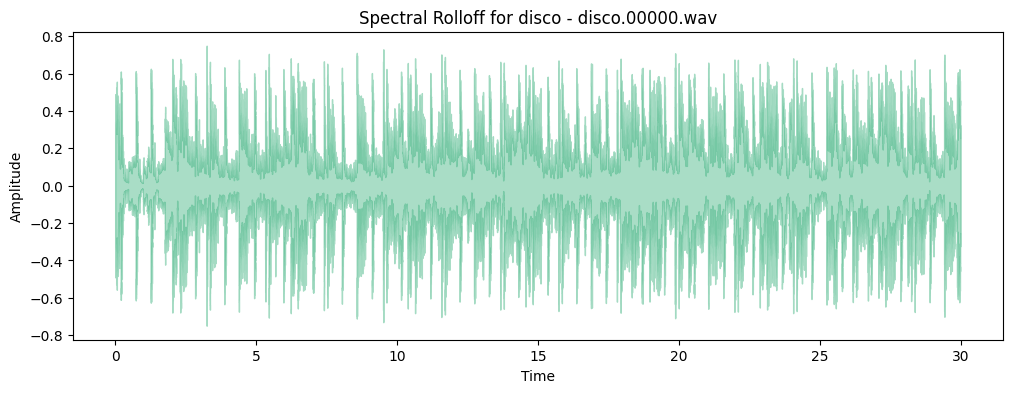

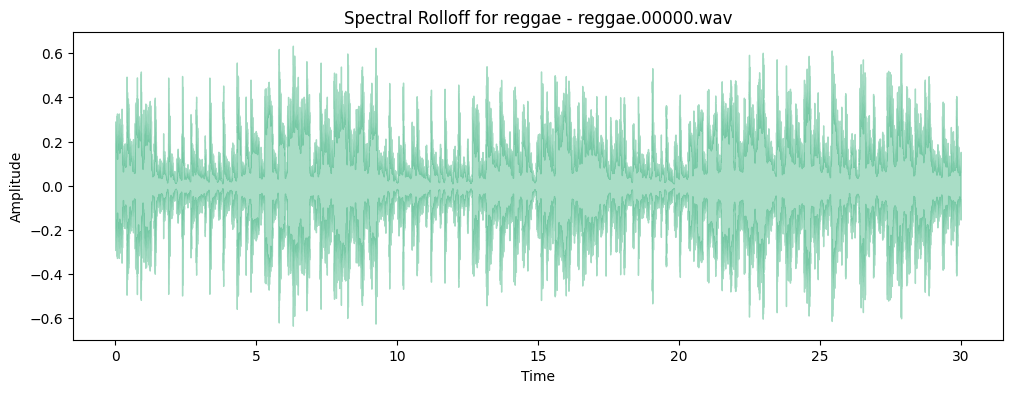

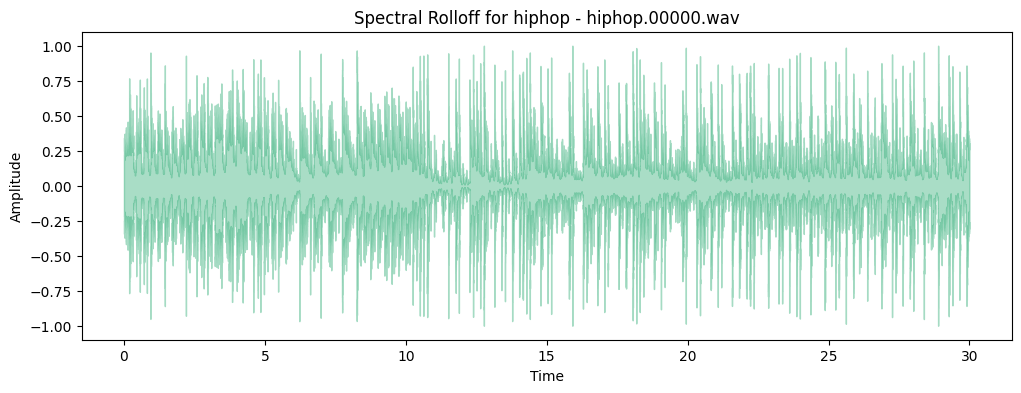

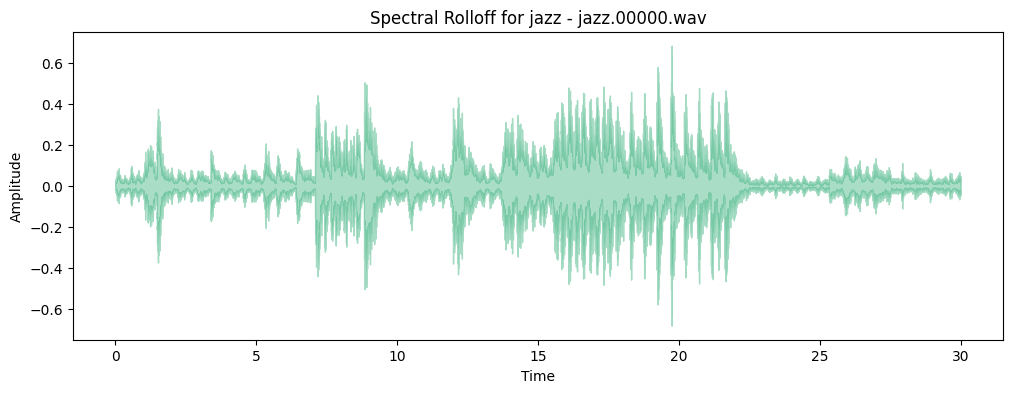

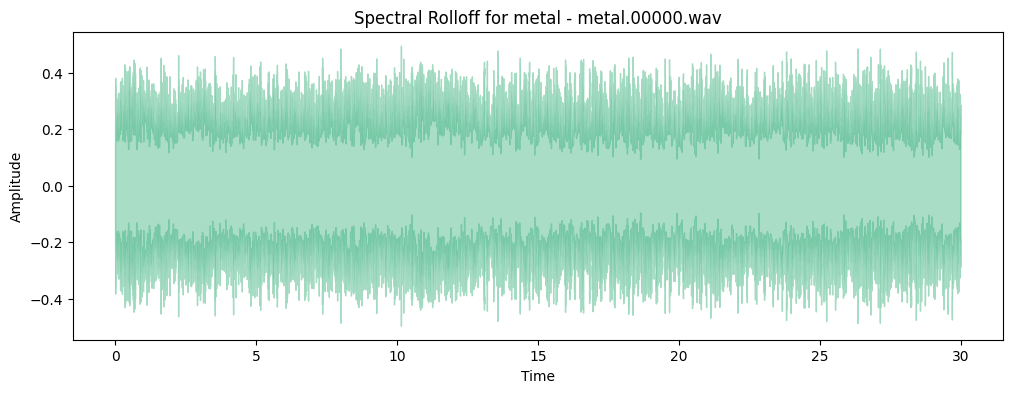

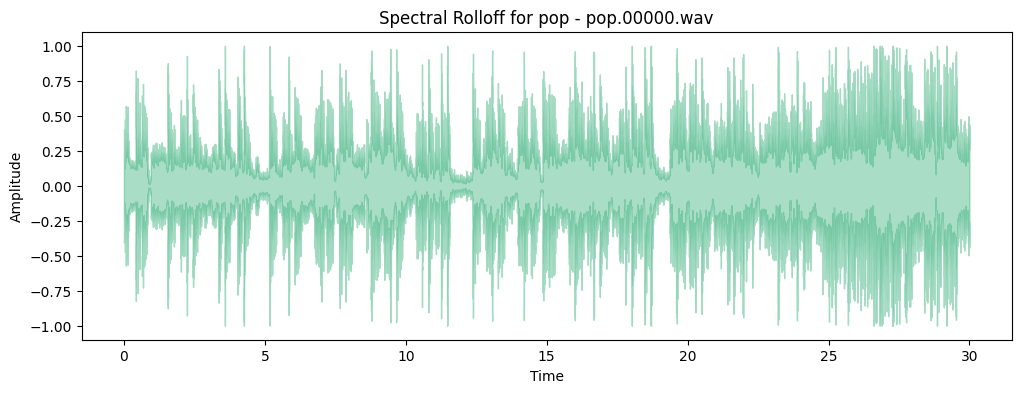

In [ ]:
from sklearn.preprocessing import normalize

for genre in genres:
    data_path = os.path.join(gtzan_dir, genre, f"{genre}.00000.wav")
    data, sr = librosa.load(data_path, duration=30.0, sr=None)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(data, sr=sr, alpha=0.4, color="#29AA72")
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title(f"Spectral Rolloff for {genre} - {genre}.00000.wav")
    plt.show()

#### Zero Crossing Rate

a zero crossing is said to occur if successive samples have different
algebraic signs. The rate at which zero crossings occur is a simple measure of the frequency content of a
signal. Zero-crossing rate is a measure of number of times in a given time interval/frame that the
amplitude of the speech signals passes through a value of zero

In [ ]:
for genre in genres:
    data_path = os.path.join(gtzan_dir, genre, f"{genre}.00000.wav")
    data, sr = librosa.load(data_path, duration=30.0, sr=None)

    zero_crossings = librosa.zero_crossings(data, pad=False)
    print(f"The number of zero-crossing in {genre} is : ", sum(zero_crossings))

The number of zero-crossing in blues is :  55012
The number of zero-crossing in classical is :  65071
The number of zero-crossing in country is :  70946
The number of zero-crossing in rock is :  59764
The number of zero-crossing in disco is :  63841
The number of zero-crossing in reggae is :  64790
The number of zero-crossing in hiphop is :  97627
The number of zero-crossing in jazz is :  51957
The number of zero-crossing in metal is :  121276
The number of zero-crossing in pop is :  83949


## Creating CSV for Processing

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os

def is_audio_valid(file_path):
    try:
        with open(file_path, 'rb') as f:
            header = f.read(12)
            return header[:4] == b'RIFF' and header[8:12] == b'WAVE'
    except Exception as e:
        print(f"Error validating {file_path}: {e}")
        return False

data_list = []

for genre in genres:
    genre_path = os.path.join(gtzan_dir, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_path = os.path.join(genre_path, file)

            # Validate audio
            if not is_audio_valid(file_path):
                print(f"Invalid audio file: {file_path}")
                continue

            try:
                y, sr = librosa.load(file_path, duration=30.0, sr=None)

                # Extract features
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rms = librosa.feature.rms(y=y)
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
                harmony, perceptr = librosa.effects.harmonic(y), librosa.effects.percussive(y)
                tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

                data_row = [
                    file,
                    len(y),
                    np.mean(chroma_stft), np.var(chroma_stft),
                    np.mean(rms), np.var(rms),
                    np.mean(spectral_centroid), np.var(spectral_centroid),
                    np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
                    np.mean(rolloff), np.var(rolloff),
                    np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                    np.mean(harmony), np.var(harmony),
                    np.mean(perceptr), np.var(perceptr),
                    tempo
                ]

                for i in range(13):
                    data_row.extend([np.mean(mfcc[i]), np.var(mfcc[i])])

                data_row.append(genre)

                data_list.append(data_row)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

columns = ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var',
           'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
           'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var',
           'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var',
           'perceptr_mean', 'perceptr_var', 'tempo']

for i in range(13):
    columns.extend([f'mfcc{i+1}_mean', f'mfcc{i+1}_var'])
columns.append('label')
df = pd.DataFrame(data_list, columns=columns)
df.to_csv('gtzan_features.csv', index=False)

print("Feature extraction complete. Data saved to gtzan_features.csv.")

Invalid audio file: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav
Feature extraction complete. Data saved to gtzan_features.csv.
